In [ ]:
from models.datasets import MonumentsDataset
from models import datasets
from models.utils import get_train_transform, collate_fn
from models import fasterrcnn
from datasets import class_list
from torch.utils.data import DataLoader

In [ ]:
model = fasterrcnn.fasterrcnn_resnet50_fpn(num_classes=17)

In [ ]:
import torch
model_path=r"D:\Major\train\bg class removed\model10.pth"

model.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
# weights=torch.load(model_path)

In [ ]:
model.eval()

In [ ]:
# change this to actual classes in the training dataset
clases=['kiranteshwor mahadev', 'charumati', 'ume_maheshwara', 'jaya bageshwori', 'birupakshya', 'kumaristhan', 'Naxal Bhagwati', 'golden temple', 'Ram Mandir', 'Krishna_temple _kobahal', 'chakku bakku', 'uma maheshwor', 'Jalbinayak', 'Maitidevi Temple', 'guyeshwori', 'nagarmandap shree kriti bihar']

In [ ]:
TEST_DIR = r"D:\Major\code\dataset\MajorV2\test_set"
dataset = MonumentsDataset(TEST_DIR, 512, 512, clases, get_train_transform())

In [ ]:
import torch
indices = torch.randperm(len(dataset)).tolist()
print(len(indices))
print(indices[:20])

In [ ]:
train_set = torch.utils.data.Subset(dataset, indices[:-500])
eval_set=torch.utils.data.Subset(dataset, indices[-500:])

In [ ]:
len(eval_set)

In [ ]:
valid_loader = DataLoader(
    dataset,
    batch_size=5,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
    )

In [ ]:
model.to(DEVICE)

In [ ]:
from torch import tensor
predictions=[{'boxes': tensor([[ 84.1036,  76.5165, 271.7503, 443.8830],[ 84.1036,  76.5165, 271.7503, 443.8830],
                    [ 84.1036,  76.5165, 271.7503, 443.8830],
                    [ 84.1036,  76.5165, 271.7503, 443.8830],]), 
              'labels': tensor([1, 1, 4,6]),
              'scores': tensor([0.9965,0.8, 0.2779, 0.0586])},
             {'boxes': tensor([[239.2319, 219.7705, 343.4445, 404.7963]]),
              'labels': tensor([5]),
              'scores': tensor([0.9982])},
             {'boxes': tensor([[ 77.5203,  86.0100, 506.1534, 484.8054]]),
              'labels': tensor([12]),
              'scores': tensor([0.9954])},
             {'boxes': tensor([[134.1839, 174.5545, 394.9434, 375.4676],
                               [106.7353, 121.3933, 373.4354, 412.4706]]),
              'labels': tensor([8, 2]),
              'scores': tensor([0.9917, 0.0847])},
             {'boxes': tensor([[106.1037,  84.3046, 465.6261, 400.9447],
                               [146.9601, 165.3507, 469.2495, 417.4515],
                               [ 61.8506,  23.7119, 470.3089, 432.0762],
                               [ 86.0900,  59.0844, 436.2623, 460.5981],
                               [134.8938,  92.4572, 458.3427, 414.5243],
                               [ 36.1431,  89.5182, 480.6086, 381.3042],
                               [140.2368, 103.6454, 453.7489, 434.0392]]),
              'labels': tensor([ 3,  8,  4, 12,  6,  8,  7]),
              'scores': tensor([0.8088, 0.4658, 0.2955, 0.2125, 0.1203, 0.0985, 0.0970])}]

targets=[{'boxes': tensor([[ 84.1036,  76.5165, 271.7503, 443.8830],
                    ]), 
              'labels': tensor([1, ]),
              'scores': tensor([0.9965])},
             {'boxes': tensor([[239.2319, 219.7705, 343.4445, 404.7963]]),
              'labels': tensor([5]),
              'scores': tensor([0.9982])},
             {'boxes': tensor([[ 77.5203,  86.0100, 506.1534, 484.8054]]),
              'labels': tensor([8]),
              'scores': tensor([0.9954])},
             {'boxes': tensor([[134.1839, 174.5545, 394.9434, 375.4676]]),
              'labels': tensor([8]),
              'scores': tensor([0.9917])},
             {'boxes': tensor([[106.1037,  84.3046, 465.6261, 400.9447]
                              ]),
              'labels': tensor([3]),
              'scores': tensor([0.8088])}]

In [ ]:
def filter_preds(predicted,threshold=0.6):
    filtered_predictions = []
    scores = []

    for pred in predicted:
        scores = pred['scores']
        indices = scores > threshold
        if indices.any():
            filtered_boxes = pred['boxes'][indices]
            filtered_labels = pred['labels'][indices]
            filtered_scores = pred['scores'][indices]
            filtered_pred = {'boxes': filtered_boxes,
                             'labels': filtered_labels,
                             'scores': filtered_scores}
        else:
            filtered_boxes = torch.tensor([[0, 0, 0, 0]])
            filtered_labels = torch.tensor([0])
            filtered_scores =torch.tensor([1])
            filtered_pred = {'boxes': filtered_boxes,
                             'labels': filtered_labels,
                             'scores': filtered_scores}
        filtered_predictions.append(filtered_pred)
    return filtered_predictions

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from torch import tensor
def sort_predictions(predictions,targets,threshold=0.6):
    target_labels=[]
    pred_labels=[]
    pred_scores=[]
    for target,prediction in zip(targets,predictions):
        for i, box in enumerate(prediction['boxes']):
            match=0
            for j, pbox in enumerate(target['boxes']):
                intersection=(min(box[2],pbox[2])-max(box[0],pbox[0]))*(min(box[3],pbox[3])-max(box[1],pbox[1]))
                union=(box[2]-box[0])*(box[3]-box[1])+ (pbox[2]-pbox[0])*(pbox[3]-pbox[1])-intersection
                iou=intersection/union
                if (iou>0.6):
                    match+=1
                    label=target['labels'][j]
                    output=prediction['labels'][i]
                    score=prediction['scores'][i]
                    target_labels.append(label)
                    pred_scores.append(score)
                    pred_labels.append(output)
            if (match==0):
                label=tensor(0)
                output=prediction['labels'][i]
                score=prediction['scores'][i]
                target_labels.append(label)
                pred_scores.append(score)
                pred_labels.append(output)
        for i, box in enumerate(target['boxes']):
            match=0
            for j, pbox in enumerate(prediction['boxes']):
                intersection=(min(box[2],pbox[2])-max(box[0],pbox[0]))*(min(box[3],pbox[3])-max(box[1],pbox[1]))
                union=(box[2]-box[0])*(box[3]-box[1])+ (pbox[2]-pbox[0])*(pbox[3]-pbox[1])-intersection
                iou=intersection/union
                if (iou>0.6):
                    match+=1
            if (match==0):
                output=tensor(0)
                score=tensor(1)
                label=target['labels'][i]
                pred_scores.append(score)
                target_labels.append(label)
                pred_labels.append(output)
    return target_labels,pred_labels,pred_scores

In [ ]:
filtered_predictions=filter_preds(predictions,0.6)
target_labels, pred_labels,_=sort_predictions(filtered_predictions,targets,0.6)                
conf_matrix = confusion_matrix(target_labels, pred_labels)
print(target_labels)
print(pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
# generate classification report for the predictions
from sklearn.metrics import classification_report
report=classification_report(target_labels,pred_labels)
print(report)

In [ ]:
original=[]
predicted=[]
imgs=0
with torch.no_grad():
    for batch in valid_loader:
        images, targets = batch
        images = list(image.to(DEVICE) for image in images)
        imgs+=len(images)
        target = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]  
        original.extend(target)
        predictions = model(images)
        predicted.extend(predictions)
print(imgs)

OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 2.00 GiB total capacity; 1.21 GiB already allocated; 0 bytes free; 1.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
filtered_predictions=filter_preds(predicted,0.6)
target_labels, pred_labels,pred_scores = sort_predictions(filtered_predictions,original,0.6)                
conf_matrix = confusion_matrix(target_labels, pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
# plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=None, bbox_inches='tight', format='png')
plt.show()

In [ ]:
report=classification_report(target_labels,pred_labels)
print(report)

In [ ]:
def class_PR(report):
    class_report_lines = report.split('\n')[2:-3]  # Exclude header and footer lines
    class_precision = {}
    class_recall = {}
    class_support = {}
    for line in class_report_lines:
        class_info = line.strip().split()
        if(len(class_info)==0):
            continue
        class_name = class_info[0]
        class_precision[class_name] = float(class_info[1])
        class_recall[class_name] = float(class_info[2])
        class_support[class_name] = int(class_info[-1])

def avg_PR(report):
    avg_report=report.split('\n')[-4:]
    for line in avg_report:
        class_info = line.strip().split()
        class_name = class_info[0]
        if (class_name=='weighted'):
            precision=class_info[2]
            recall=class_info[3]
            print(precision,recall)
            return precision,recall

In [ ]:
def PR_list(original,predicted):
    precisions=[]
    recalls=[]
    threshold=0
    precision=0
    recall=0
    while threshold<=1.0:
        filtered_predictions=filter_preds(predicted,threshold)
        target_labels, pred_labels,_=sort_predictions(filtered_predictions,original,0.6) 
        report=classification_report(target_labels,pred_labels)
        precision,recall=avg_PR(report)
        precisions.append(precision)
        recalls.append(recall)
        threshold+=0.025
    return precisions,recalls
        

In [ ]:
precisions,recalls=PR_list(original,predicted)

In [ ]:
precisions.reverse()


In [ ]:
print(precisions)
print(recalls)

In [ ]:
# Smooth interpolation for continuous curv

precision = [float(p) for p in precisions]
recall = [float(r) for r in recalls]

# Plot the PR curve
plt.plot(recall, precision, linestyle='-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

# Set x-axis and y-axis limits to 0 and 1
# plt.xlim(0, 1)
# plt.ylim(0, 1)

plt.show()







In [ ]:
def count_box(targets):
    count=0
    for target in targets:
        for box in target['boxes']:
            count+=1
    return count

In [ ]:
count_box(original)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming you have the following:
# pred_labels: Predicted class labels
# pred_scores: Predicted confidence scores
# target_labels: Ground truth class labels (correct labels)
# threshold_range: List of confidence score thresholds

# Create an empty list to store the precision and recall values
precisions = []
recalls = []
count=count_box(original)
# Loop through each threshold in the threshold range
threshold=0
while threshold<=1:
    filtered_predictions=filter_preds(predictions,threshold)
    target_labels, pred_labels,pred_scores = sort_predictions(predicted,original,0.6) 
    # Filter predictions based on the current threshold
    filtered_indices = [i for i, score in enumerate(pred_scores) if score > threshold]
    filtered_pred_labels = [pred_labels[i] for i in filtered_indices]
    
    # Compute true positive, false positive, and false negative detections
    true_positives = np.sum(np.in1d(filtered_pred_labels, target_labels))
    false_positives = len(filtered_pred_labels) - true_positives
    false_negatives = np.sum(np.in1d(target_labels, filtered_pred_labels, invert=True))
    
    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / count
    
    # Append precision and recall to the lists
    precisions.append(precision)
    recalls.append(recall)
    threshold+=0.01

# Plot the PR curve
plt.plot(recalls, precisions, marker='o', linestyle='-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming 'original' is a list of dictionaries where each dictionary contains the 'image' tensor and 'boxes' tensor for the ground truth bounding boxes
# Assuming 'predicted' is a list of dictionaries where each dictionary contains the 'image' tensor and 'boxes' tensor for the predicted bounding boxes

# Convert the 'image' tensors and 'boxes' tensors from the dictionaries to NumPy arrays
images_cpu = [image.cpu() for image in photos]

# Convert the CPU tensors to NumPy arrays
original_np = [image.numpy() for image in images_cpu]
predicted_np = original_np
predicted_label=[item['labels'].cpu().numpy() for item in filtered_predictions]
# original_np = [item['image'].cpu().numpy() for item in original]
original_boxes = [item['boxes'].cpu().numpy() for item in original]
# predicted_np = [item['image'].cpu().numpy() for item in predicted]
predicted_boxes = [item['boxes'].cpu().numpy() for item in filtered_predictions]

# Visualize the original and predicted images with bounding boxes
fig, axs = plt.subplots(len(original), 2, figsize=(10, 5 * len(original)))

for i in range(len(original)):
    image_bgr = original_np[i].transpose(1,2,0)[:, :, ::-1]
    # Original Image
    axs[i, 0].imshow(image_bgr)  # Assuming original images are in CHW format
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original')

    # Predicted Image with Bounding Boxes
    axs[i, 1].imshow(image_bgr)  # Assuming predicted images are in CHW format
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Predicted')

    # Add ground truth bounding boxes to the original image
    for box in original_boxes[i]:
        rect = patches.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none'
        )
        axs[i, 0].add_patch(rect)
#         axs[i,0].text(
#             box[0], box[1] - 5, f'{clases[int(predicted_label[i])-1]}', color='r', fontsize=10,
#             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
#         )
        axs[i, 0].add_patch(rect)
        axs[i,0].text(
            box[0], box[1] - 5, f'jal binayak', color='r', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
        )


    # Add predicted bounding boxes to the predicted image
    for box in predicted_boxes[i]:
        rect = patches.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='g', facecolor='none'
        )
#         axs[i, 1].add_patch(rect)
#         axs[i,1].text(
#             box[0], box[1] - 5, f'{clases[int(predicted_label[i])-1]}', color='r', fontsize=10,
#             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
#         )
        axs[i, 1].add_patch(rect)
        axs[i,1].text(
            box[0], box[1] - 5, f'kiranteswor mahadev', color='r', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
        )

plt.tight_layout()
plt.show()

In [ ]:
from torch import tensor
predictions=[{'boxes': tensor([[ 84.1036,  76.5165, 271.7503, 443.8830],
                     [122.5349, 163.8023, 265.8016, 401.8894],
                     [ 27.4188,  55.2320, 286.0090, 452.0019]]), 
              'labels': tensor([1, 1, 4]),
              'scores': tensor([0.9965, 0.2779, 0.0586])},
             {'boxes': tensor([[239.2319, 219.7705, 343.4445, 404.7963]]),
              'labels': tensor([5]),
              'scores': tensor([0.9982])},
             {'boxes': tensor([[ 77.5203,  86.0100, 506.1534, 484.8054]]),
              'labels': tensor([12]),
              'scores': tensor([0.9954])},
             {'boxes': tensor([[134.1839, 174.5545, 394.9434, 375.4676],
                               [106.7353, 121.3933, 373.4354, 412.4706]]),
              'labels': tensor([8, 2]),
              'scores': tensor([0.9917, 0.0847])},
             {'boxes': tensor([[106.1037,  84.3046, 465.6261, 400.9447],
                               [146.9601, 165.3507, 469.2495, 417.4515],
                               [ 61.8506,  23.7119, 470.3089, 432.0762],
                               [ 86.0900,  59.0844, 436.2623, 460.5981],
                               [134.8938,  92.4572, 458.3427, 414.5243],
                               [ 36.1431,  89.5182, 480.6086, 381.3042],
                               [140.2368, 103.6454, 453.7489, 434.0392]]),
              'labels': tensor([ 3,  8,  4, 12,  6,  8,  7]),
              'scores': tensor([0.8088, 0.4658, 0.2955, 0.2125, 0.1203, 0.0985, 0.0970])}]

targets=[{'boxes': tensor([[ 84.1036,  76.5165, 271.7503, 443.8830],
                    ]), 
              'labels': tensor([1, ]),
              'scores': tensor([0.9965])},
             {'boxes': tensor([[239.2319, 219.7705, 343.4445, 404.7963]]),
              'labels': tensor([5]),
              'scores': tensor([0.9982])},
             {'boxes': tensor([[ 77.5203,  86.0100, 506.1534, 484.8054]]),
              'labels': tensor([12]),
              'scores': tensor([0.9954])},
             {'boxes': tensor([[134.1839, 174.5545, 394.9434, 375.4676]]),
              'labels': tensor([8]),
              'scores': tensor([0.9917])},
             {'boxes': tensor([[106.1037,  84.3046, 465.6261, 400.9447]
                              ]),
              'labels': tensor([3]),
              'scores': tensor([0.8088])}]

In [10]:
filtered_predictions = []
for pred in predictions:
    scores = pred['scores']
    indices = scores > 0.6
    if indices.any():
        filtered_boxes = pred['boxes'][indices]
        filtered_labels = pred['labels'][indices]
        filtered_scores = pred['scores'][indices]
        filtered_pred = {'boxes': filtered_boxes,
                         'labels': filtered_labels,
                         'scores': filtered_scores}
    else:
        filtered_boxes = torch.tensor([[0, 0, 0, 0]])
        filtered_labels = torch.tensor([0])
        filtered_scores =torch.tensor([0])
        filtered_pred = {'boxes': filtered_boxes,
                         'labels': filtered_labels,
                         'scores': filtered_scores}

    filtered_predictions.append(filtered_pred)

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix
pred_labels = np.concatenate([pred['labels'].cpu().numpy() for pred in filtered_predictions])
pred_scores = np.concatenate([pred['scores'].cpu().numpy() for pred in filtered_predictions])
target_labels = np.concatenate([target['labels'].cpu().numpy() for target in targets])
# Threshold the predictions based on scores (keeping only those with scores > 0.6)
threshold = 0.6
# filtered_indices = np.where(pred_scores > threshold)[0]
# pred_labels = pred_labels[filtered_indices]
# Create the confusion matrix
conf_matrix = confusion_matrix(np.sort(target_labels), np.sort(pred_labels))
print("Confusion Matrix:")
print(conf_matrix)
print(np.sort(target_labels),np.sort(pred_labels))
print(type(target_labels),pred_labels.sort())


Confusion Matrix:
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
[ 1  3  5  8 12] [ 1  3  5  8 12]
<class 'numpy.ndarray'> None


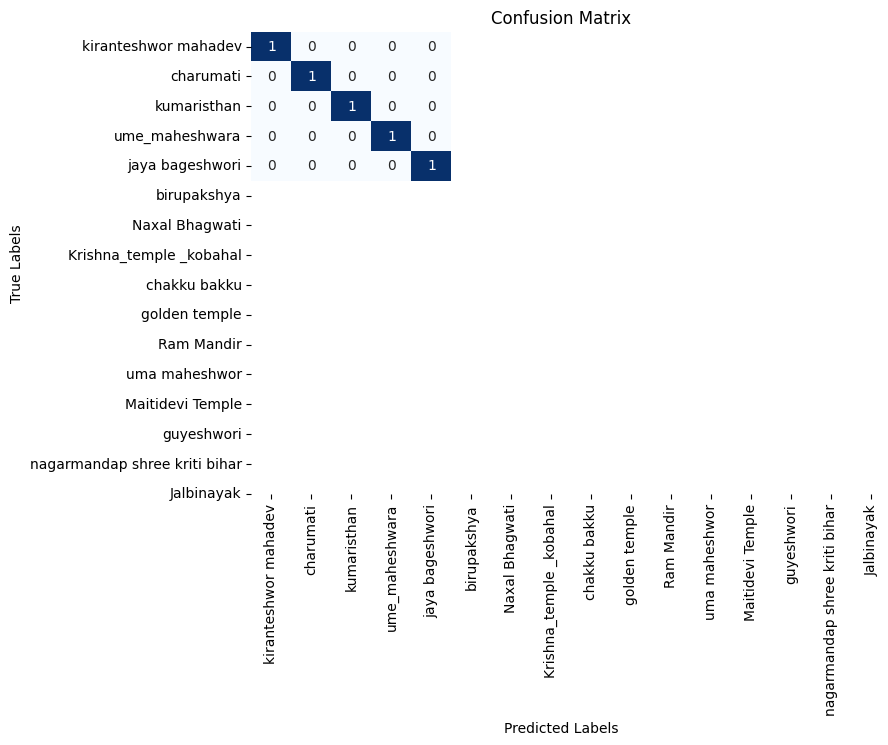

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()